## ４章のKeras版


## Policy Gradient Methods（方策勾配法）
４章で使用されている更新方法は、Sutton et al., 1999がベースとなっているみたい。
- https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf

式の導出は、以下のサイトに紹介されています。
- <a href="http://seiya-kumada.blogspot.com/2018/02/blog-post_13.html">強化学習 〜方策勾配定理の導出〜</a>

３章との違いは、行動価値関数Q(s,a)をactionを行う確率とし、モデルの最後の活性化関数にsoftmaxを使用していること。

倒立台車のように連続した空間の場合、方策ベースの手法が適しているとのことです。

### 方策勾配の更新式
$s_t$をstate、$a_t$をaction、$p(s_{t+1} | s_t, a_t)$を状態変化を表す確率分布、$r(s_t, a_t)$を即時報酬$\pi_{\theta}|(a_t|t_t)$を方策（policy）に従って行動した場合のstateとactionの列を$\tau$とします。
$$
\tau = (s_1, a_1, ... , s_T, a_T, S_{T+1})
$$
$$
p_{\theta}(\tau) = p(s_1) \prod^T_{t=1}p(s_{t|s_t)+1} | s_t, a_t) \pi_{\theta}(a_t, s_t)
$$

累積報酬の期待値$J(\theta)$を最大化するような$\pi_{\theta}$のパラメータ$\theta$を見つけます。

$$
\begin{eqnarray}
    R(\tau)    & \equiv  & \sum^T_{t=1} r(s_t, a_t) \\
    J(\theta)  & \equiv  & \mathbb{E}_{\pi_{\theta}}[R(\tau)] \\
                 & = & \sum_{\tau} R(\tau)p_{\theta}(\tau)
\end{eqnarray}
$$

以下の方策勾配定理が成り立ちます。
$$
\begin{eqnarray}
    \nabla J(\theta)  & = & \mathbb{E} \left [ \frac{\partial \pi_{\theta}(a|s)}{\partial \theta} \frac{1}{\pi_{\theta}(a|s)} Q^{\pi_{\theta}}(s, a) \right ] \\
                 & = & \mathbb{E} \left [ \nabla_{\theta} log \, \pi_{\theta} (a|s) \, Q^{\pi_{\theta}}(s, a) \right ]
\end{eqnarray}
$$

ここで、式の展開に以下の公式を使うのポイントみたいです。

$$
f \frac{d \, log(f)}{dx} = f \frac{df}{dx} \frac{1}{f} = \frac{df}{dx}
$$

In [6]:
import numpy as np
import random
from IPython.display import Image
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

# keras用のパッケージをインポート
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K

# OpenAI用パッケージをインポート
import gym

In [31]:
import seaborn as sns
import pandas as pd

def showResult(result, title='', x_axis='', y_axis='', showOriginal=False):
    def running_mean(x, N=50):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)
    
    if showOriginal:
        d = pd.DataFrame(result)
    else:
        d = pd.DataFrame(running_mean(result))
    # loss,をプロット
    sns.set()
    ax = d.plot(title=title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    plt.show()

In [8]:
D_in, H, D_out = 4, 150, 2
learning_rate = 0.0009

# 例題がleakyReLUを使っているので、合わせる。
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

# 以下のURLを参照
# https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb
# 中間層の情報を使って損失関数を定義し、評価用モデルと学習用モデルを使うところもすごい！
def createModel(learning_rate=learning_rate):
    inp = layers.Input(shape=(D_in,), name="input_x")
    adv = layers.Input(shape=(1,), name="advantages")
    x = layers.Dense(H, 
                     activation=LeakyReLU(), 
                     use_bias=False,
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    out = layers.Dense(D_out, 
                       activation="softmax", 
                       use_bias=False,
                       kernel_initializer=glorot_uniform(seed=42),
                       name="out")(x)
    
    def custom_loss(y_true, y_pred):
        # pred is output from neural network, a is action index
        # r is return (sum of rewards to end of episode), d is discount factor
        return -K.sum(adv * K.log(y_pred)) # element-wise multipliy, then sum

    model_train = Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=custom_loss, optimizer=Adam(lr=learning_rate))
    model_predict = Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [26]:
# 倒立台車のシミュレーション環境
class SimulationEnv(object):
    # コンストラクター
    def __init__(self, model_train, model_predict, game, gamma):
        self.model_train = model_train
        self.model_predict = model_predict
        self.game = game
        self.gamma = gamma
    
    # 現在の倒立台車の状態を返す
    def reset(self):
        self.transitions = []
        return game.reset()
    
    # アクションを返す
    def action(self, state):
        act_prob = model_predict.predict(state.reshape(1, D_in))[0]
        # サンプリング
        action = np.random.choice(np.array([0,1]), p=act_prob)
        return action
    
    # ディスカウント報酬（減衰率（gamma）を考慮した）を返す
    def discount_rewards(self, rewards):
        lenr = len(rewards)
        d_rewards = np.power(self.gamma,np.arange(lenr)) * rewards 
        d_rewards = (d_rewards - d_rewards.mean()) / (d_rewards.std() + 1e-07)
        return d_rewards
    
    # 次のステップに進む（状態、アクション、報酬を記録）
    def step(self, state):
        action = self.action(state)
        new_state, reward, done, info = game.step(action)
        self.transitions.append((state, action, reward))
        return (new_state, reward, done)
    
    # エピソードでの状態の遷移（transitions）を元にmodel_trainを更新
    def update(self):
        ep_len = len(self.transitions) # episode length
        preds = np.zeros(ep_len)
        rewards = np.zeros(ep_len)
        states = []
        # model_predictを使ってエピソードの各ステップのaction確率の予測値を計算
        for i in range(ep_len): #for each step in episode
            state, action, reward = self.transitions[i]
            pred = model_predict.predict(state.reshape(1, D_in))[0]
            preds[i] = pred[action]
            rewards[i] = reward
            states.append(state)
        #  ディスカウント報酬とaction確率の予測値でmodel_trainを更新
        discounted_rewards =  self.discount_rewards(rewards)
        states = np.array(states).reshape(ep_len, D_in)
        loss = model_train.train_on_batch([states, discounted_rewards] , preds)
        return loss
    
    # クローズ処理
    def close(self):
        game.close()
        

In [41]:
model_train, model_predict = createModel()
game = gym.make('CartPole-v0')
gamma = 0.99
env = SimulationEnv(model_train, model_predict, game, gamma)

MAX_DUR = 200
MAX_EPISODES = 1000

# 更新状況可視化のため、ゲームの継続時間と損失値を保持
durations = []
losses = []

# 最大エピソード回実行
for episode in range(MAX_EPISODES):
    state = env.reset()
    done = False
    for t in range(MAX_DUR): #エピソードの間繰り返す
        state, reward, done = env.step(state)
        if done:
            durations.append(t)
            break
    loss = env.update()
    losses.append(loss)
env.close()

/usr/lib/sagemath/local/lib/python2.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


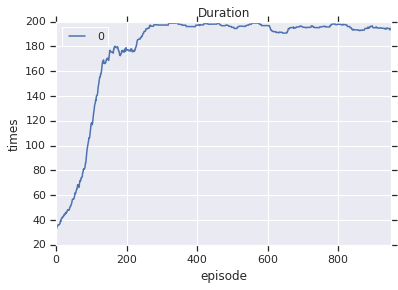

In [42]:
showResult(durations, title="Duration", x_axis="episode", y_axis="times")

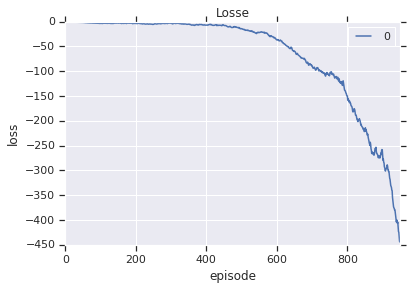

In [43]:
showResult(losses, title="Losse", x_axis="episode", y_axis="loss")

In [44]:
# ここで学習したモデルパラメータを保存
model_train.save_weights('models/param_train.hdf5')
model_predict.save_weights('models/param_predict.hdf5')

In [45]:
# 前回学習したモデルパラメータを使ってアニメーションを作成する
model_train, model_predict = createModel()
model_train.load_weights('models/param_train.hdf5')
model_predict.load_weights('models/param_predict.hdf5')

/usr/lib/sagemath/local/lib/python2.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [46]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    # gifを保存する場合
    # anim.save("images/CartPole-v0.gif", writer = 'imagemagick')
    display(display_animation(anim, default_mode='loop'))

In [53]:
MAX_DUR = 400
env = gym.make('CartPole-v0')
state = env.reset()
frames = []
for t in range(MAX_DUR):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    act_prob = model_predict.predict(state.reshape(1, D_in))[0]
    action = np.random.choice(np.array([0,1]), p=act_prob)
    print(action)
    state, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
env.close()    

0
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
0
1
0
1
0
0
1
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
1
0
1
1
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


TypeError: render() got an unexpected keyword argument 'close'


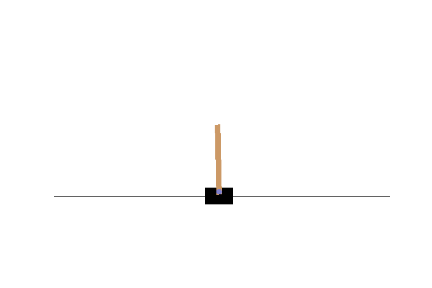
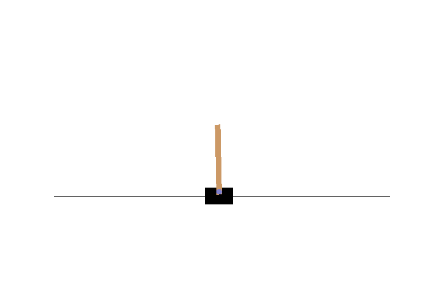
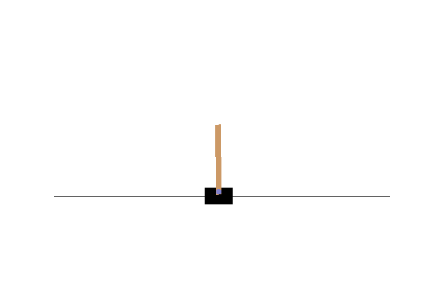
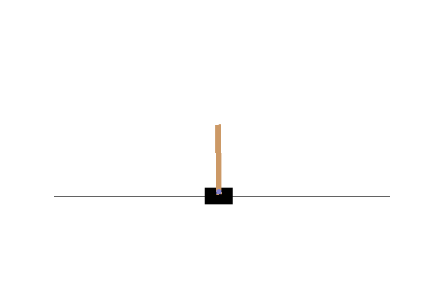
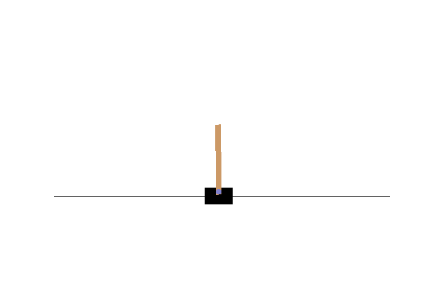
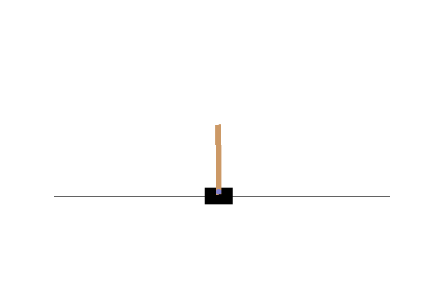
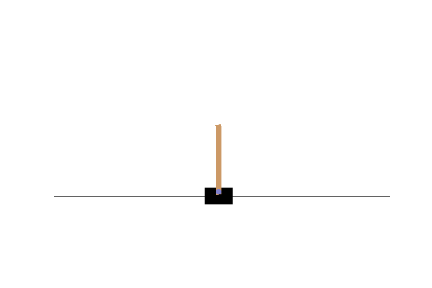
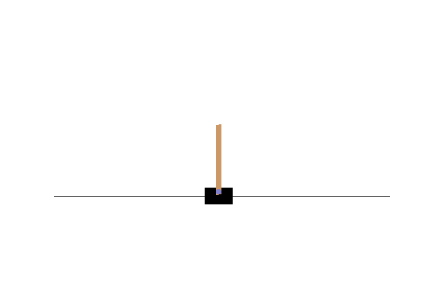
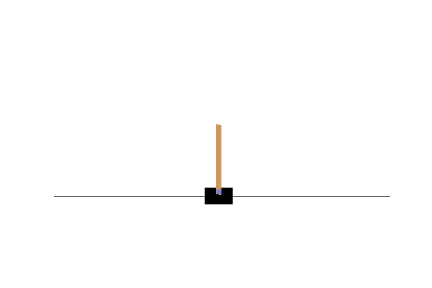
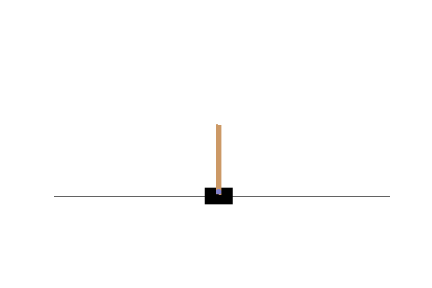
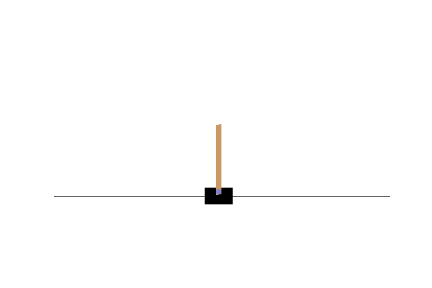
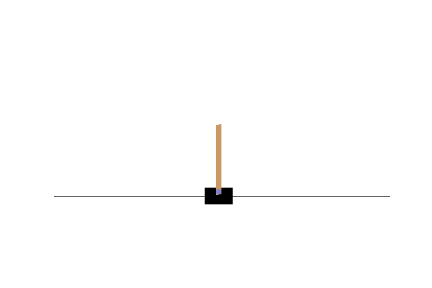
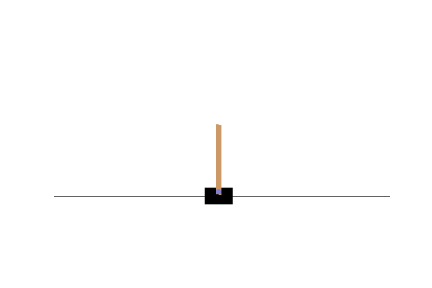
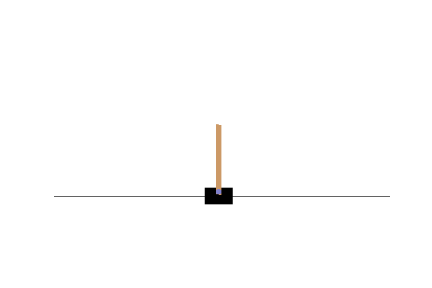
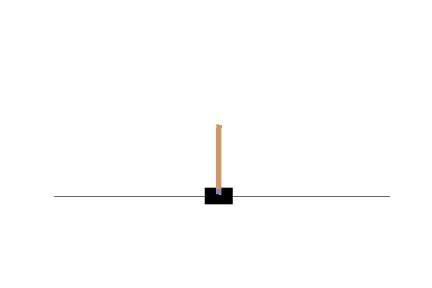
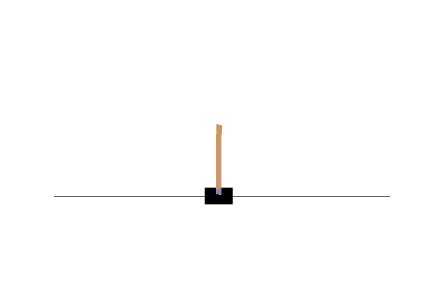
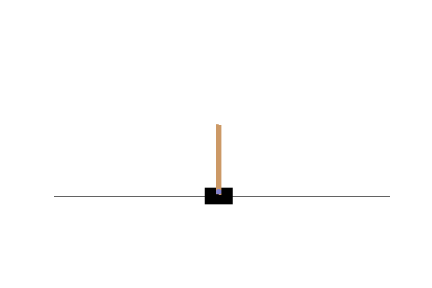
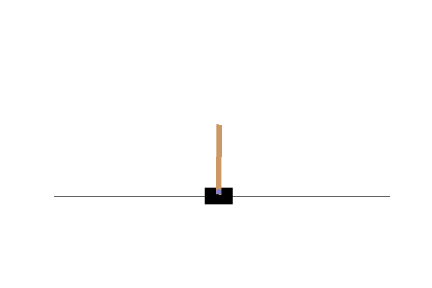
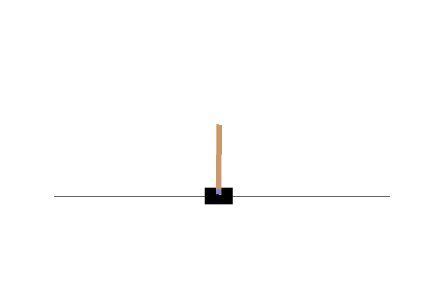
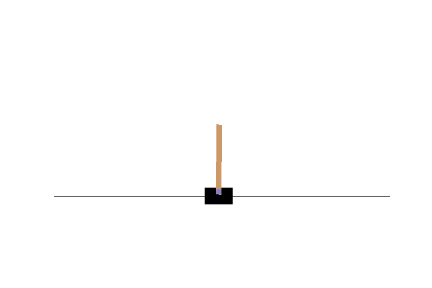
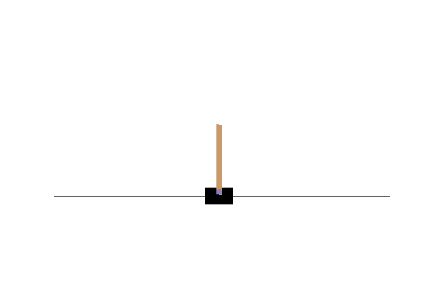
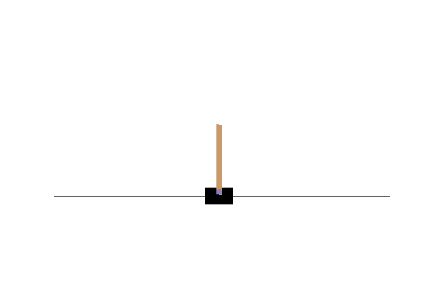
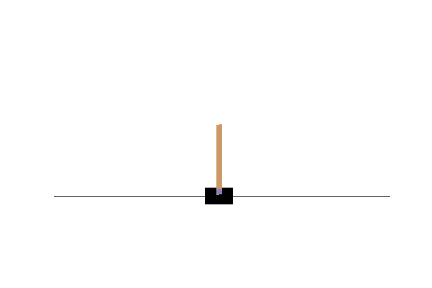
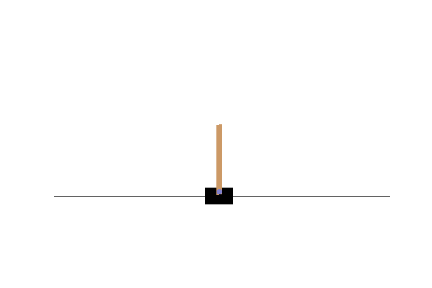
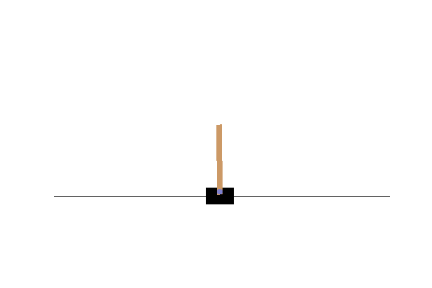
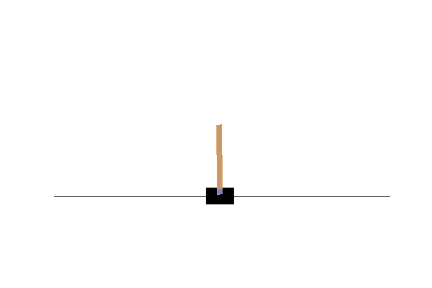
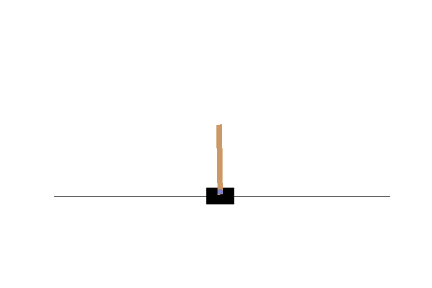
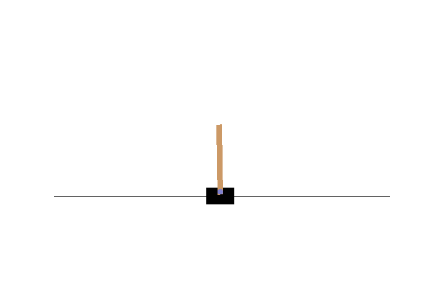
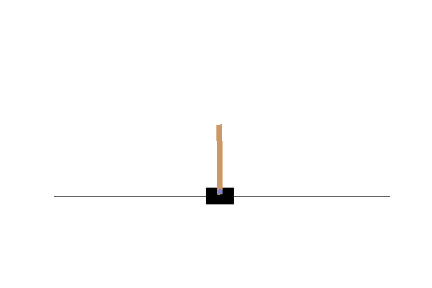
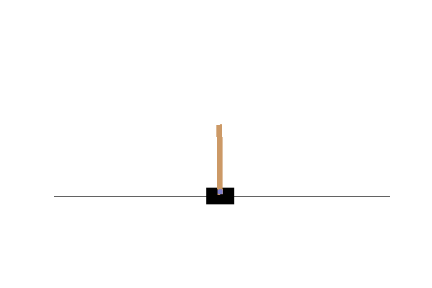
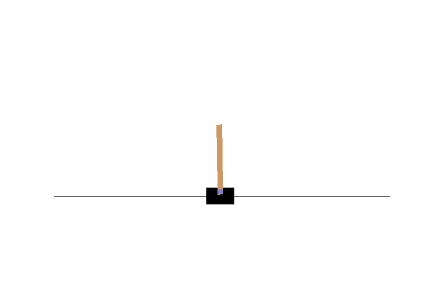
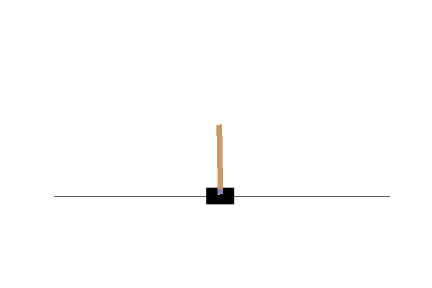
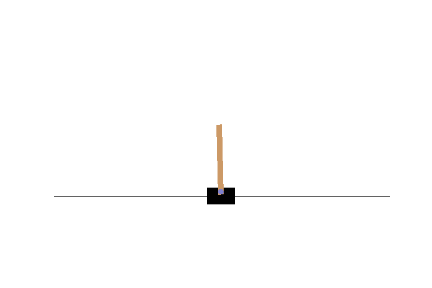
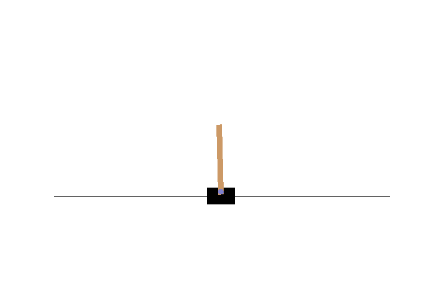
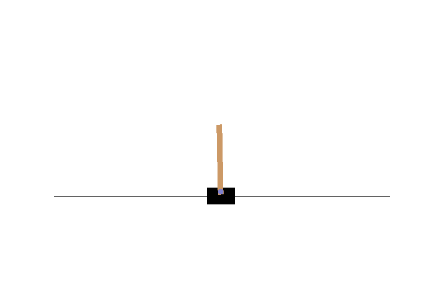
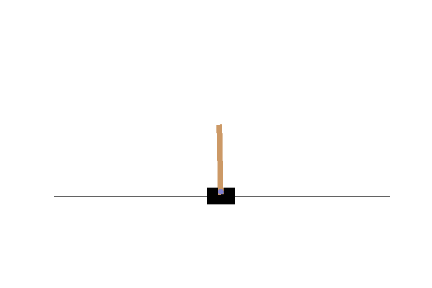
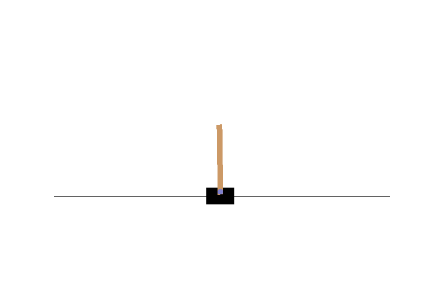
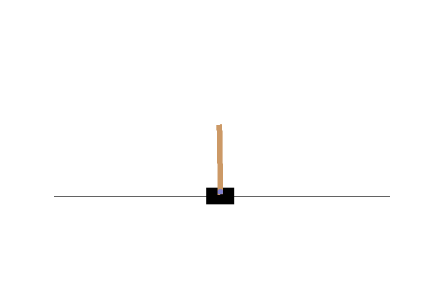
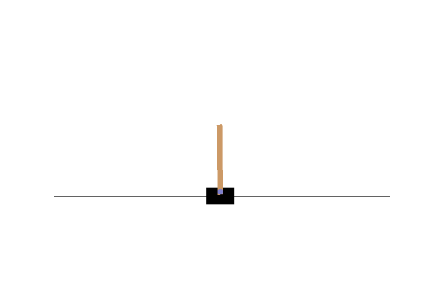
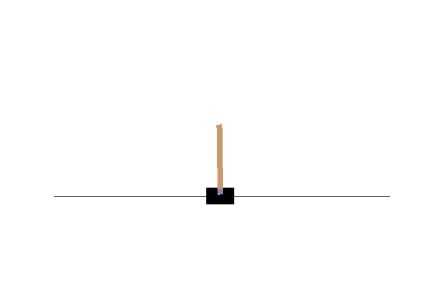
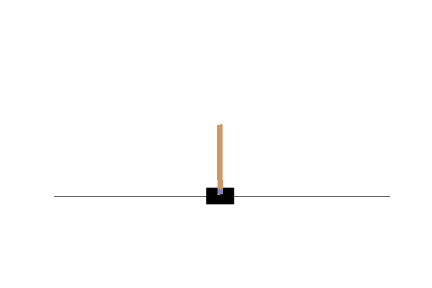
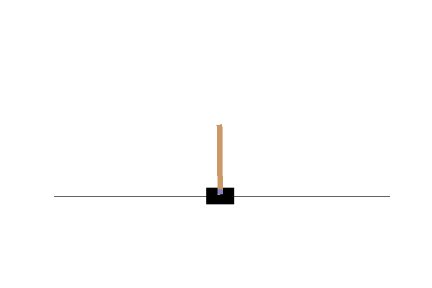
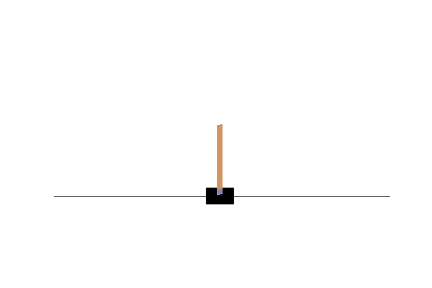
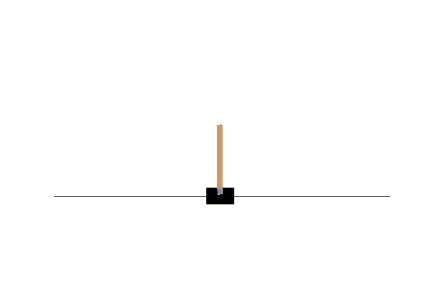
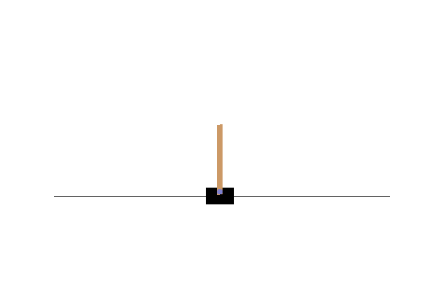
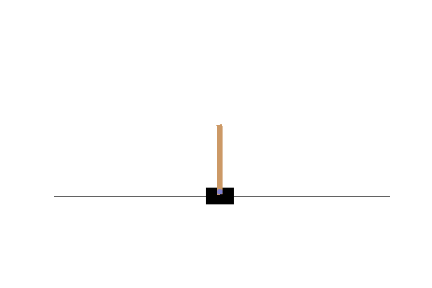
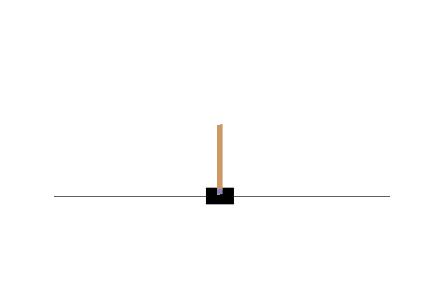
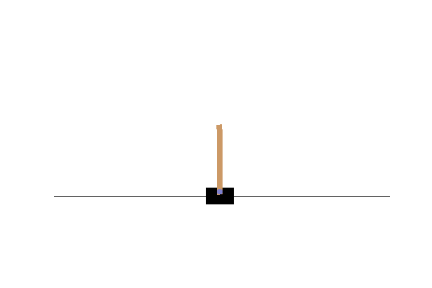
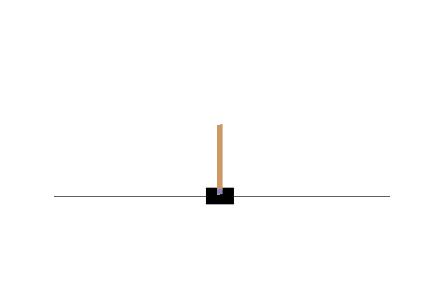
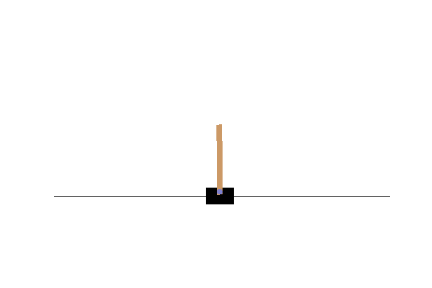
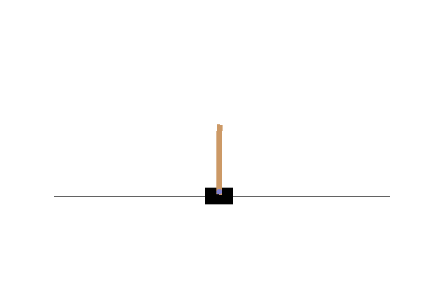
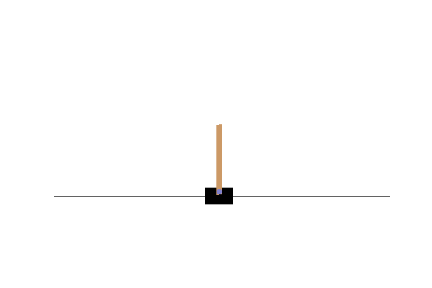
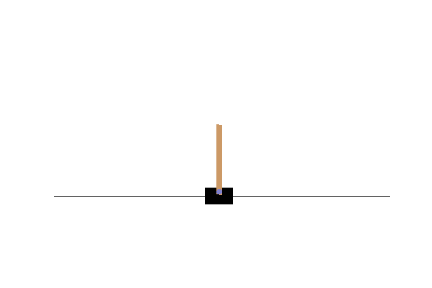
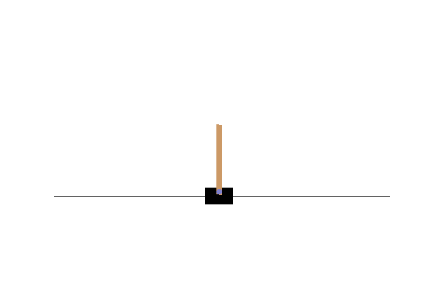
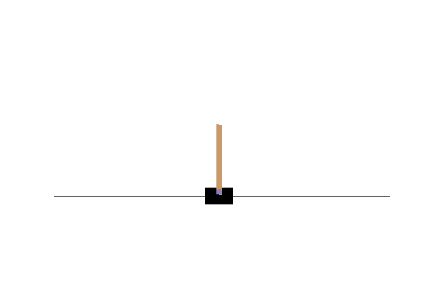
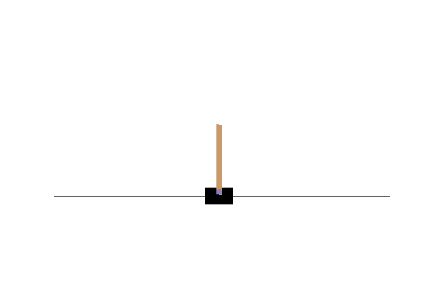
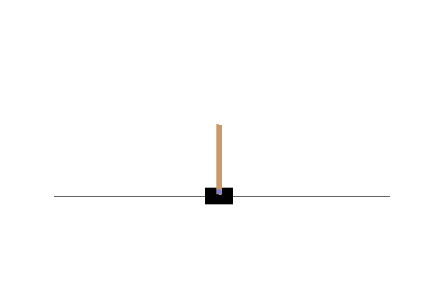
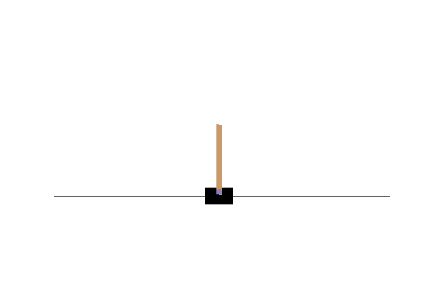
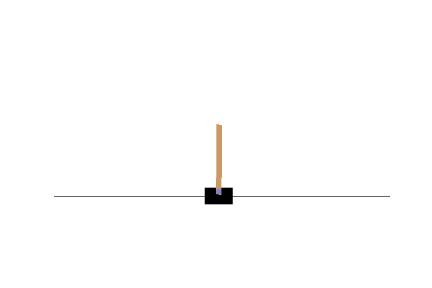
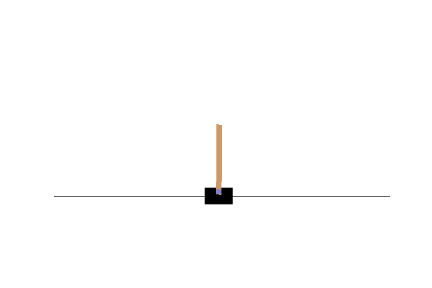
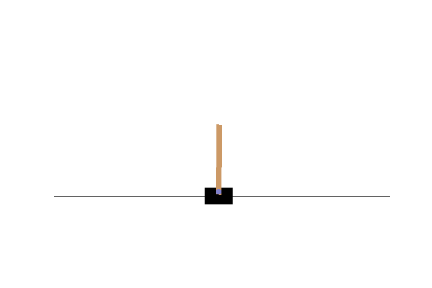
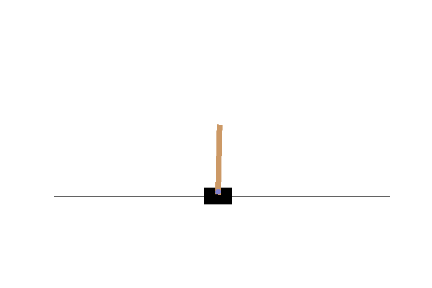
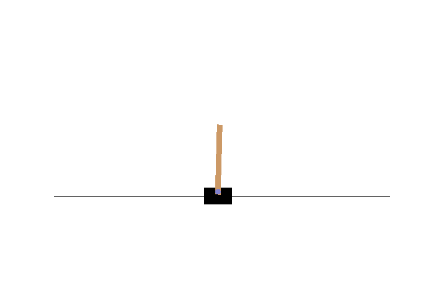
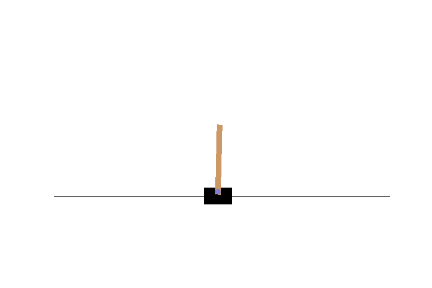
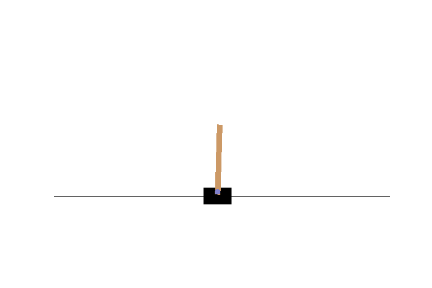
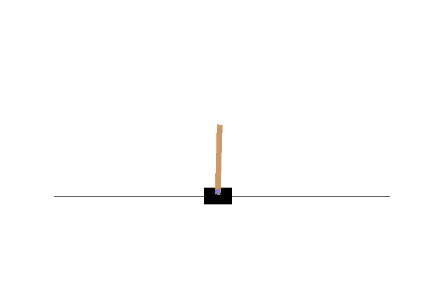
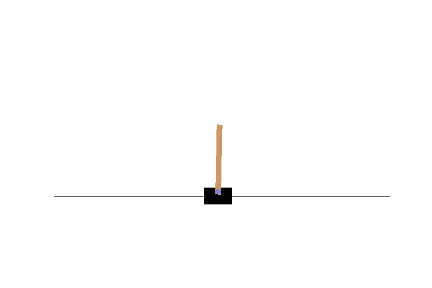
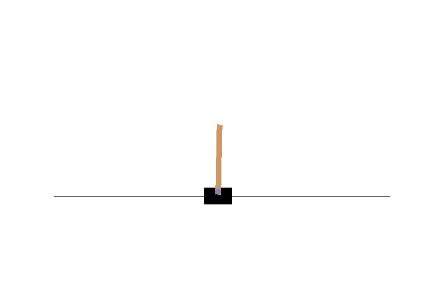
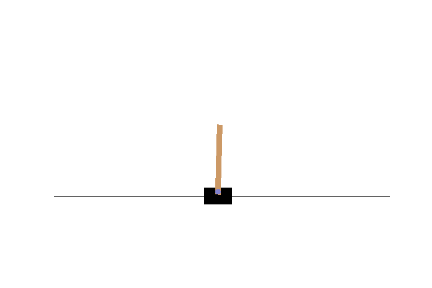
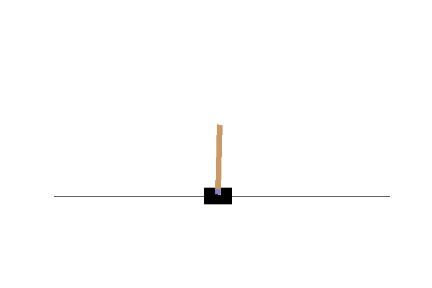
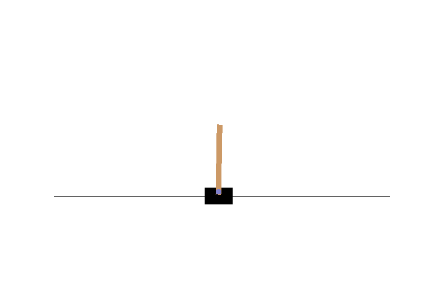
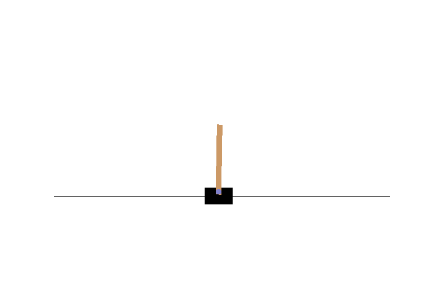
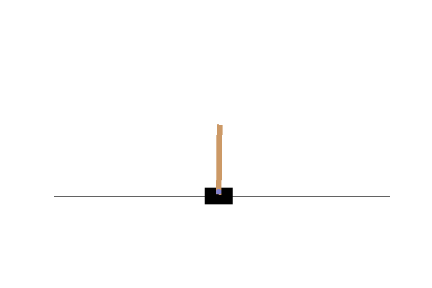
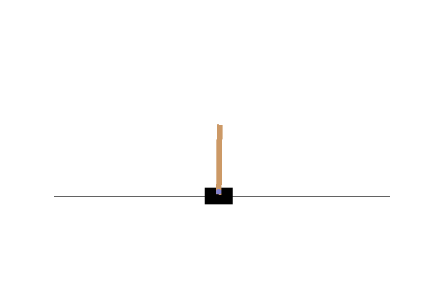
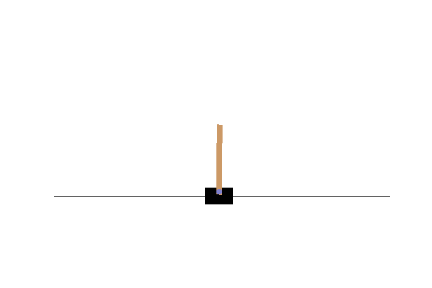
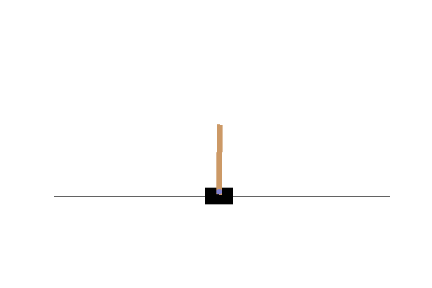
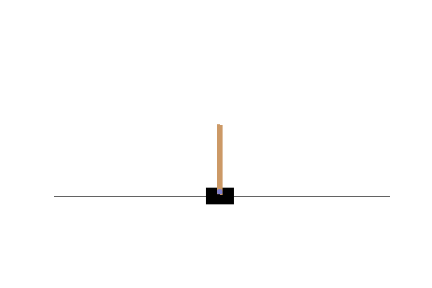
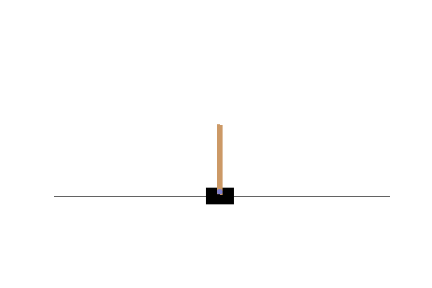
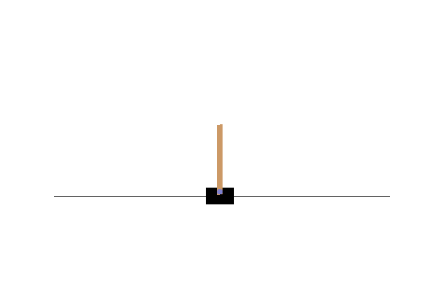
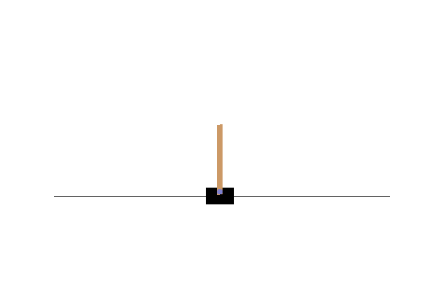
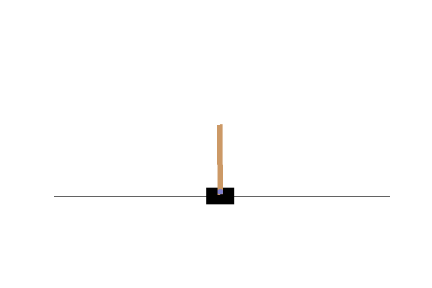
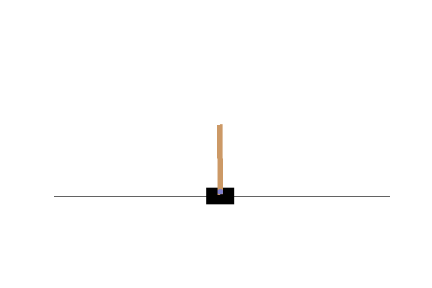
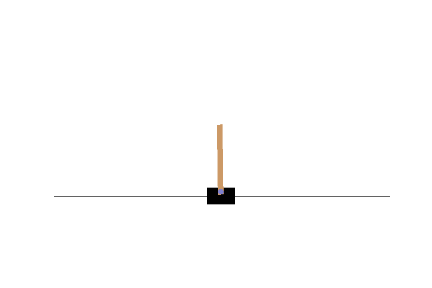
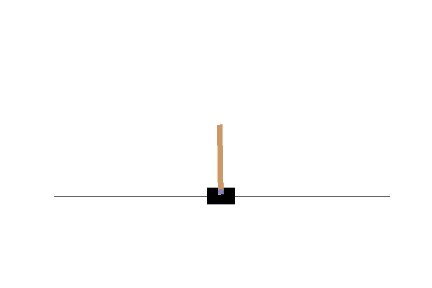
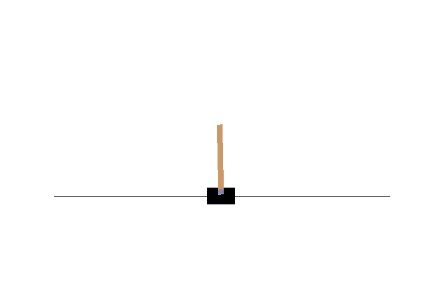
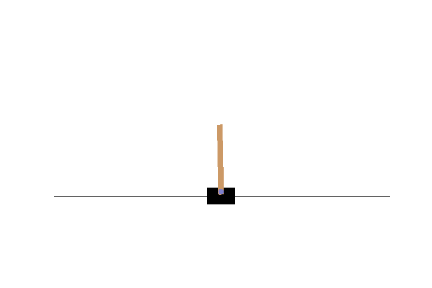
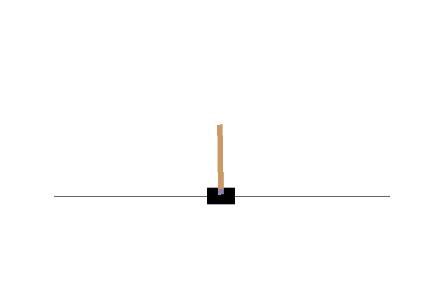
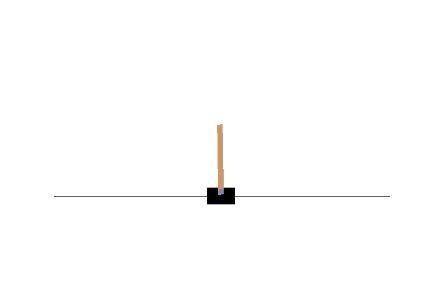
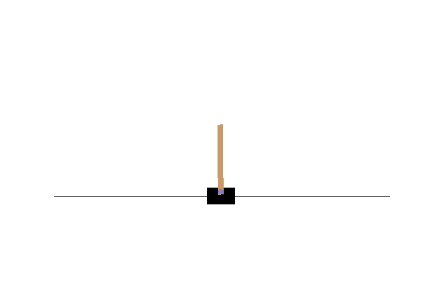
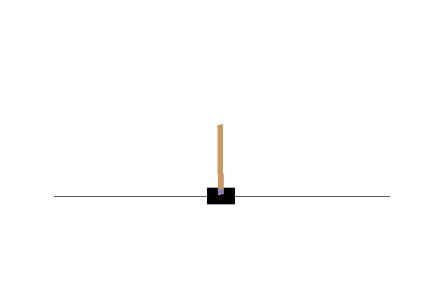
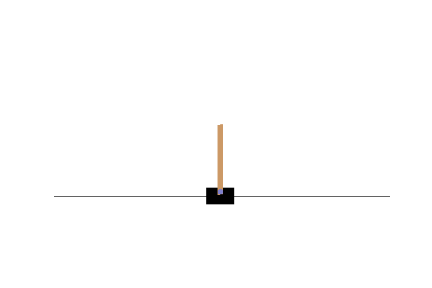
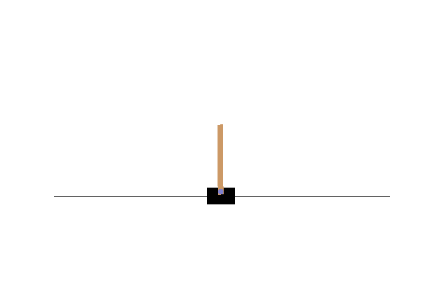
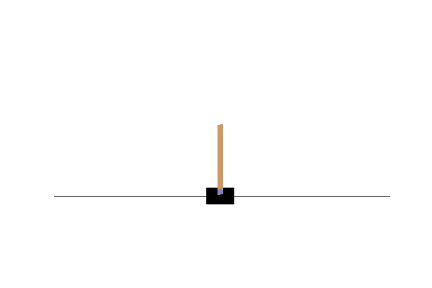
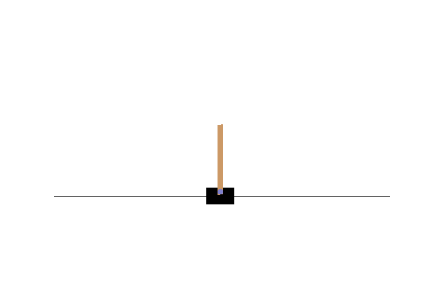
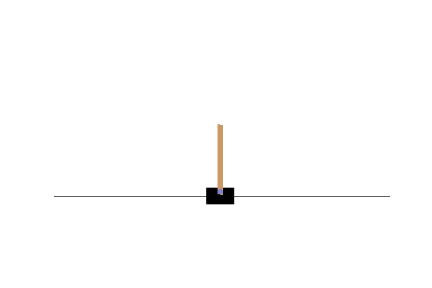
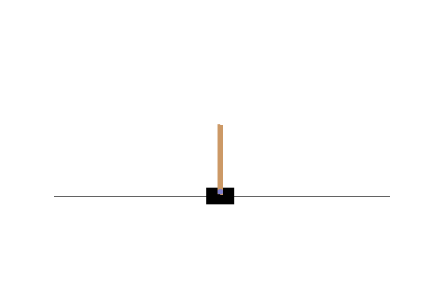
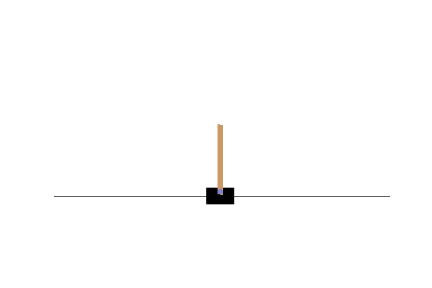
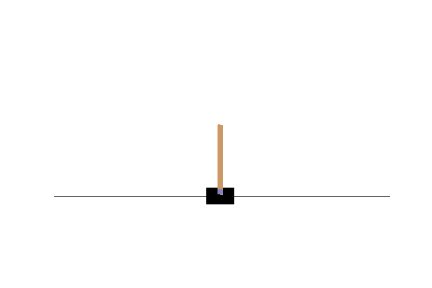
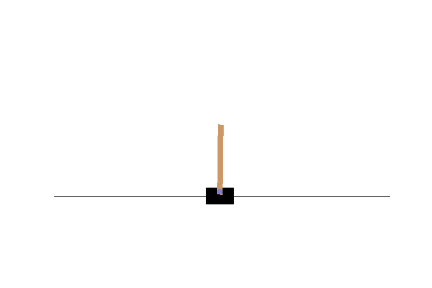
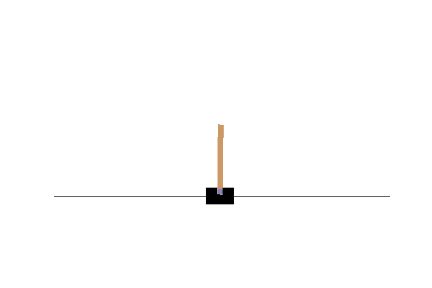
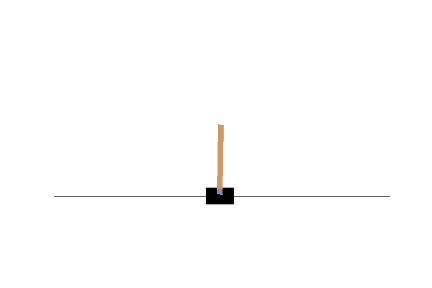
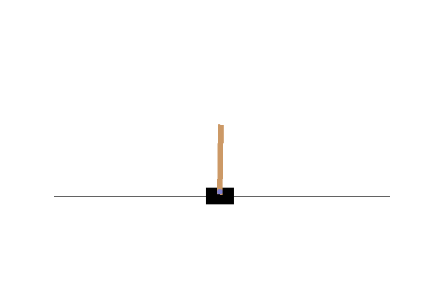
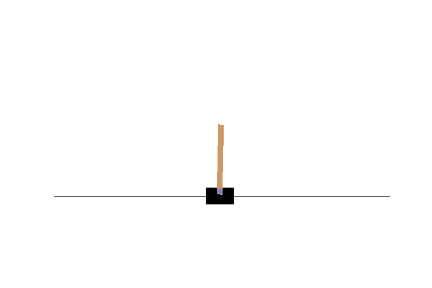
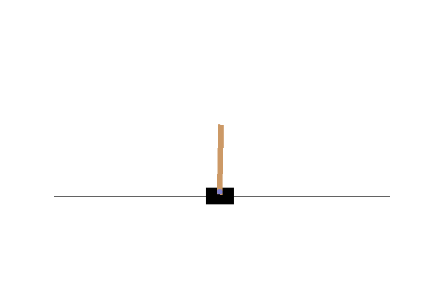
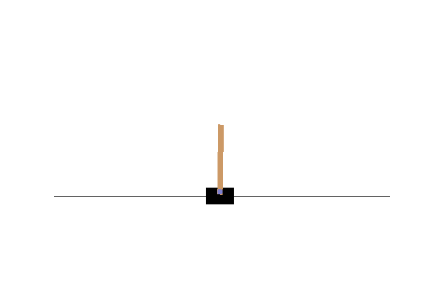
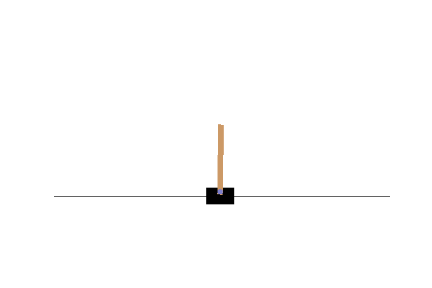
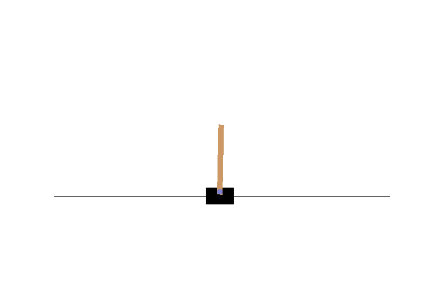
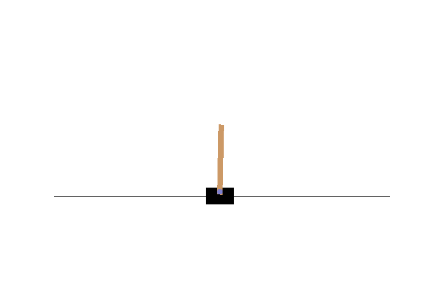
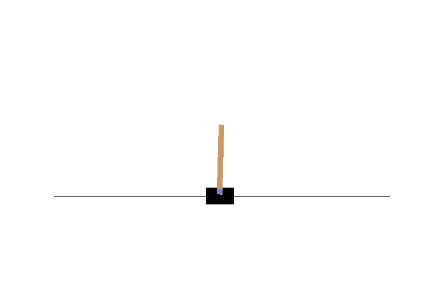
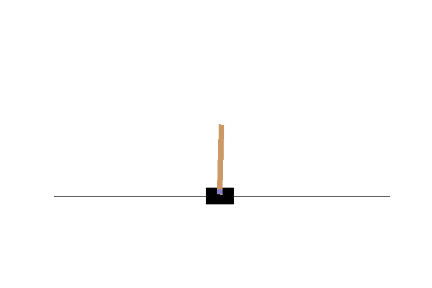
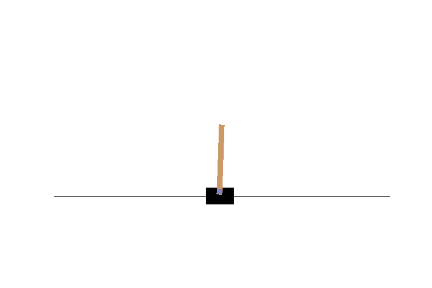
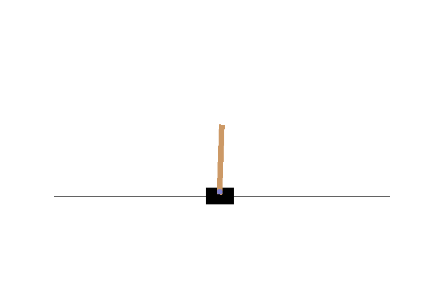
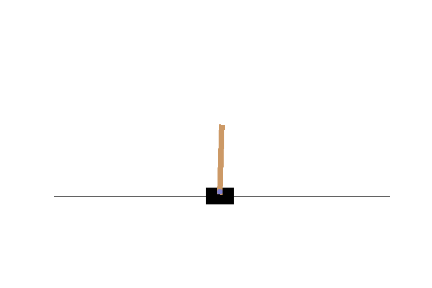
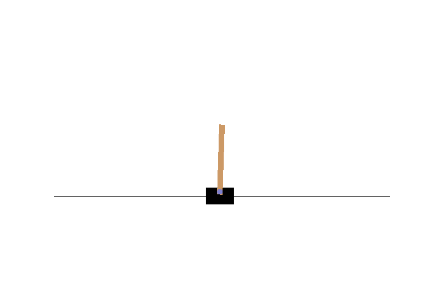
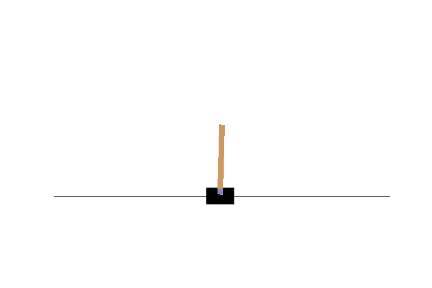
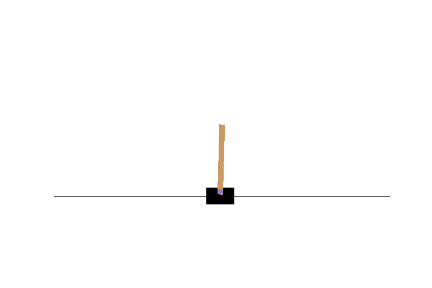
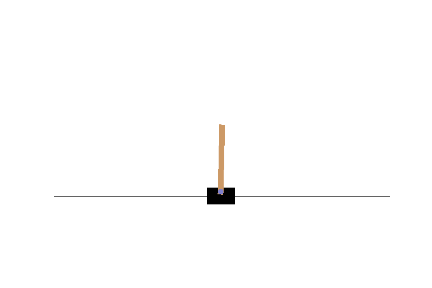
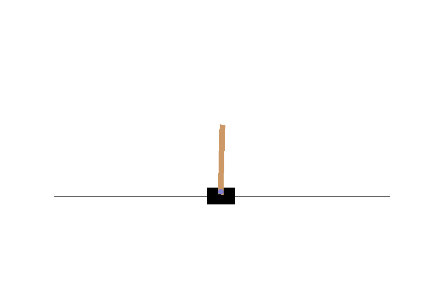
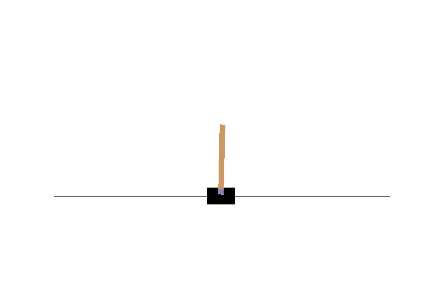
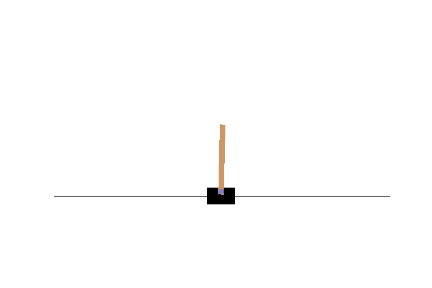
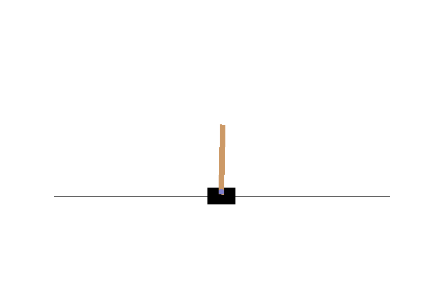
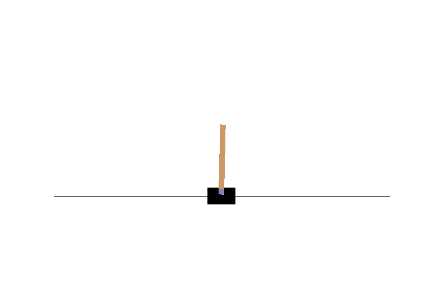
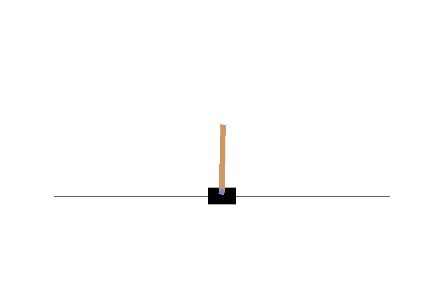
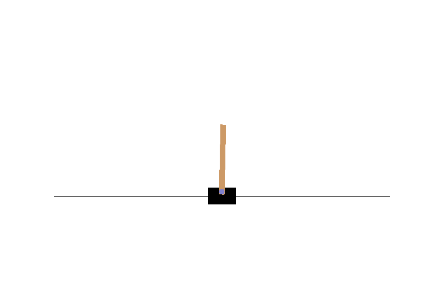
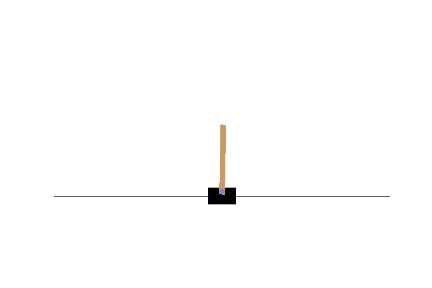
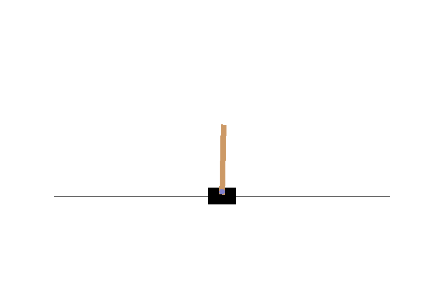
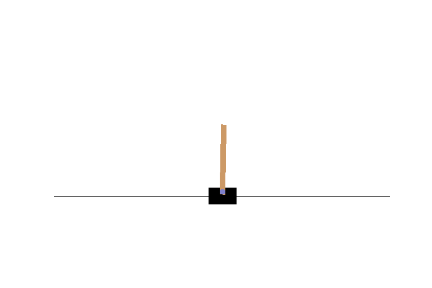
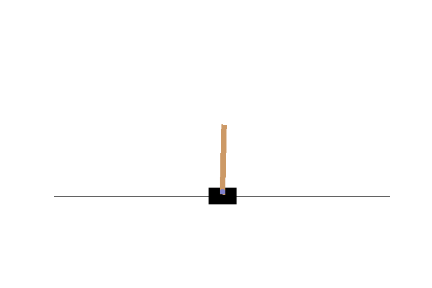
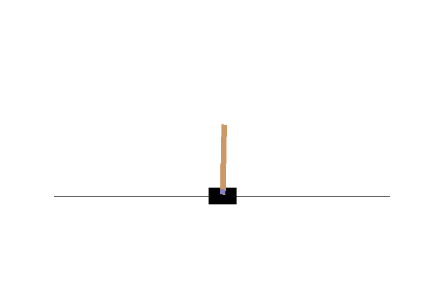
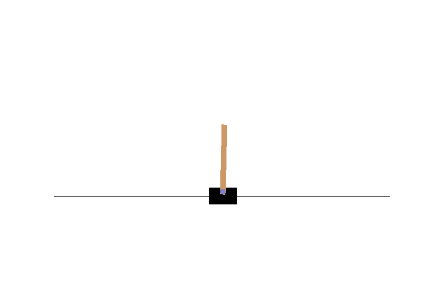
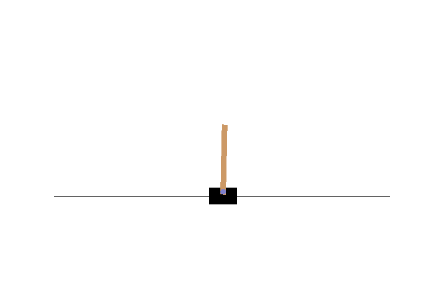
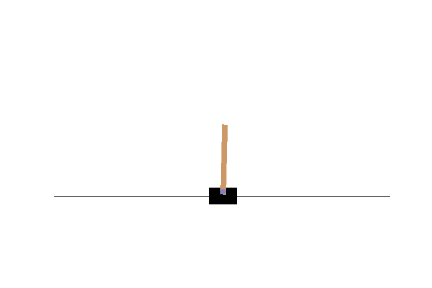
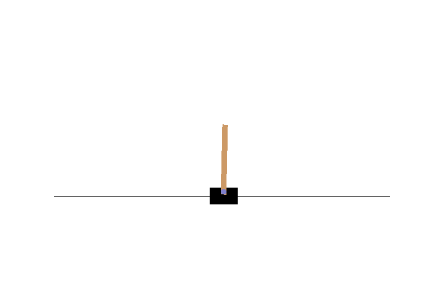
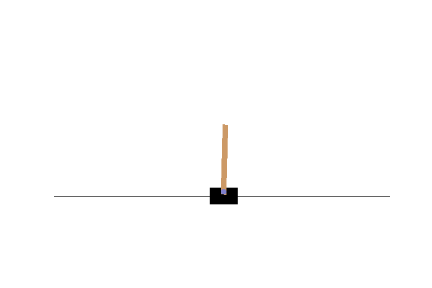
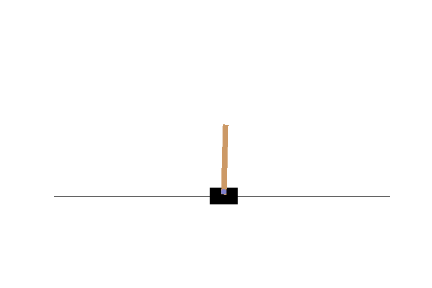
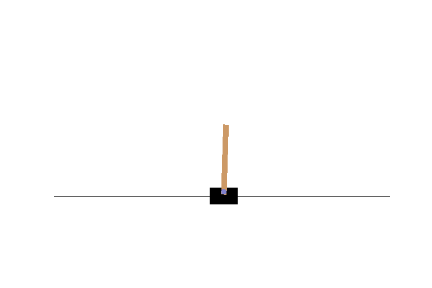
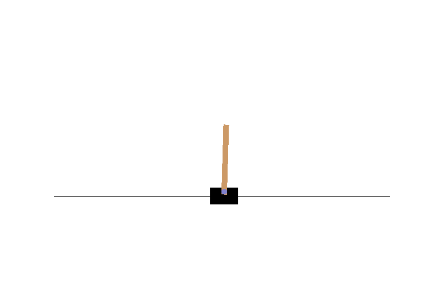
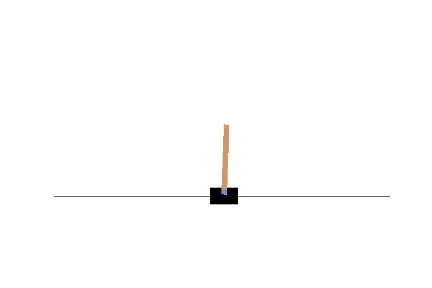
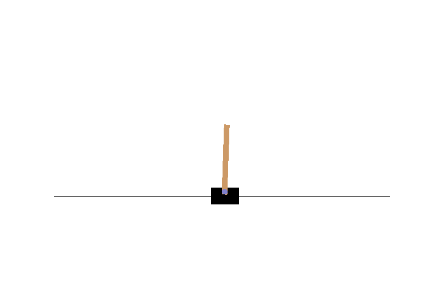
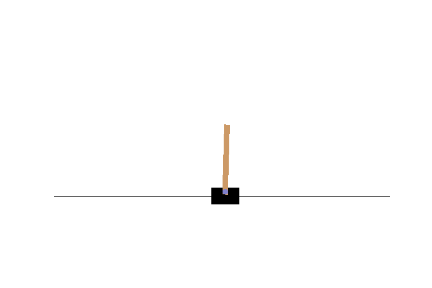
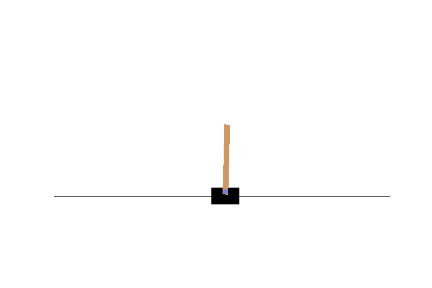
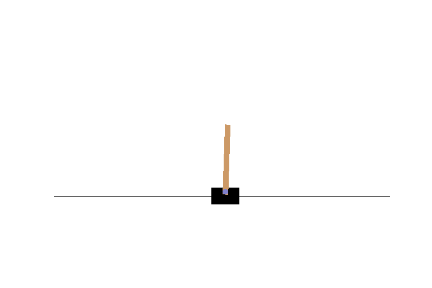
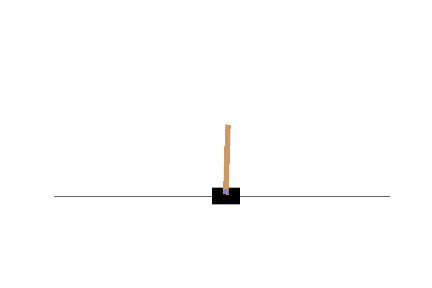
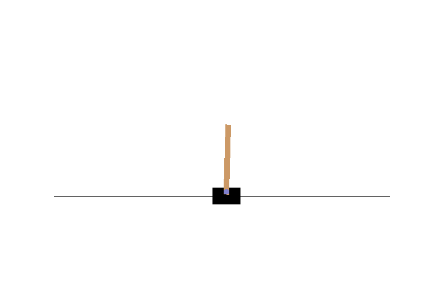
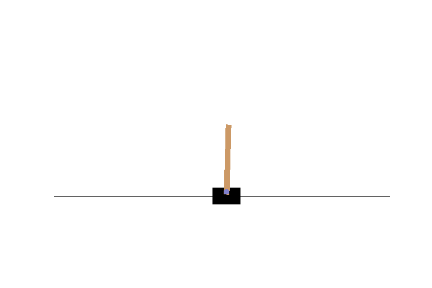
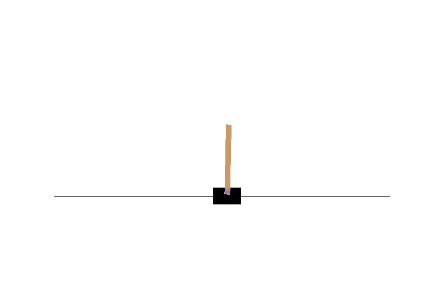
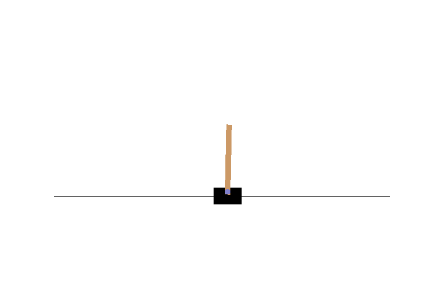
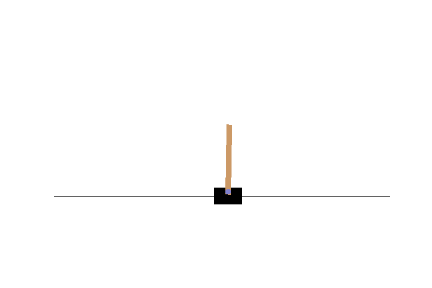
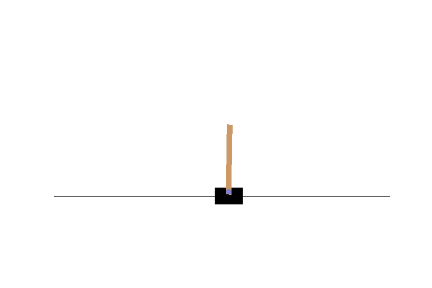
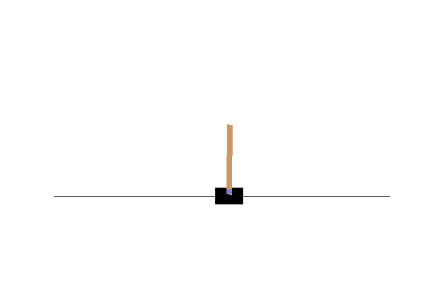
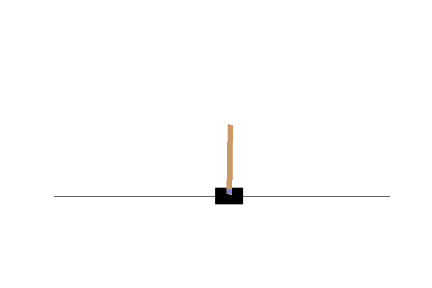
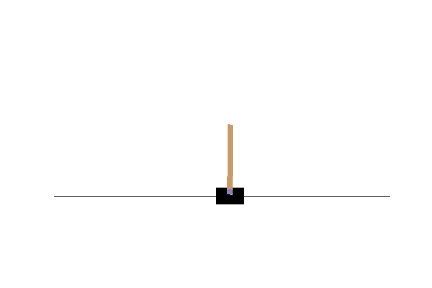
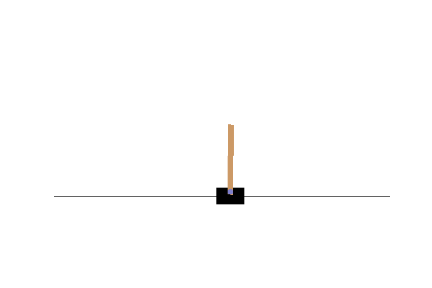
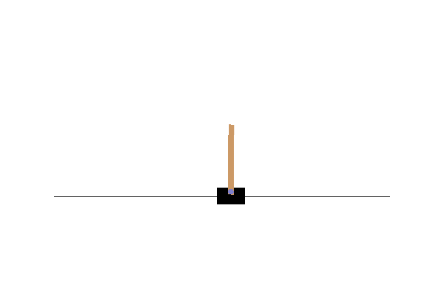
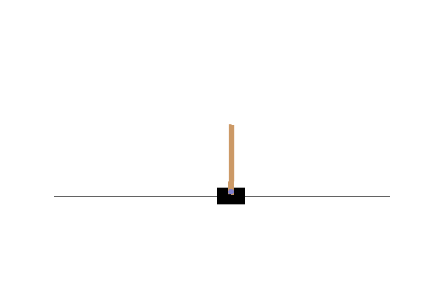
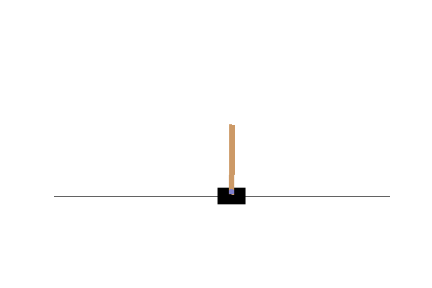
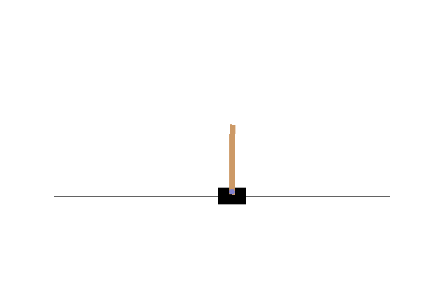
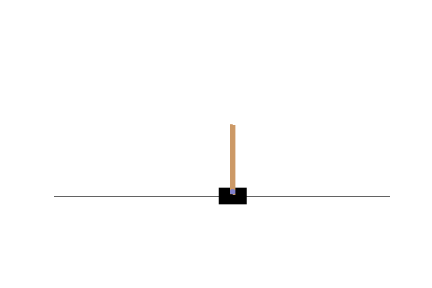
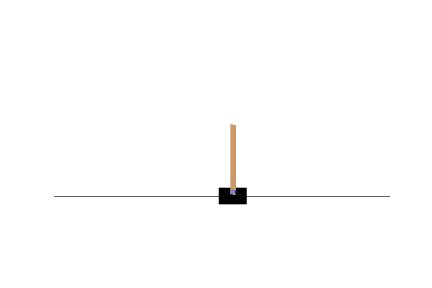
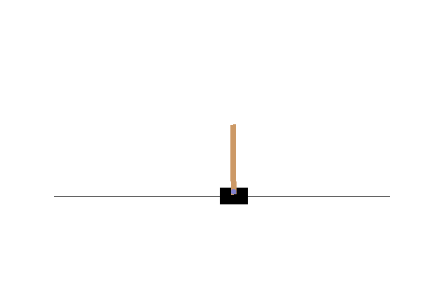
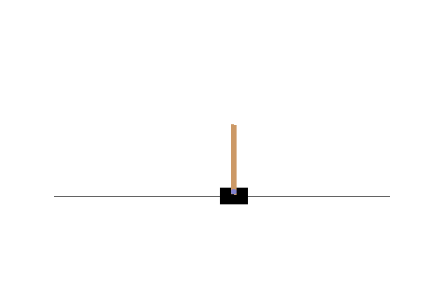
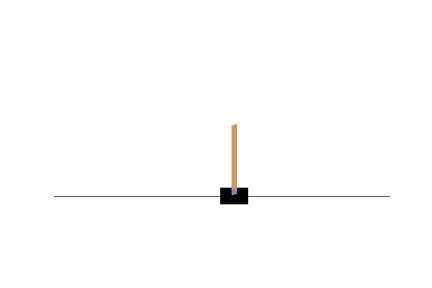
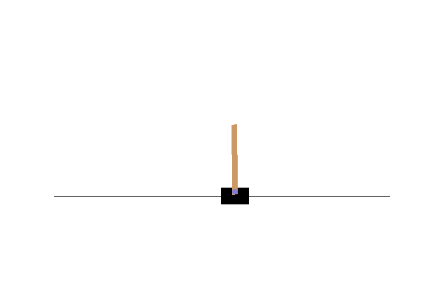
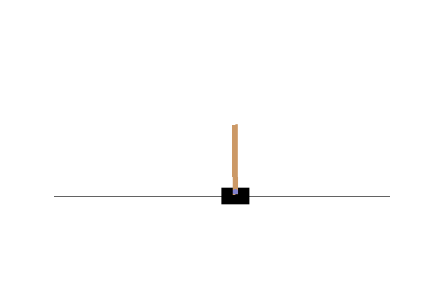
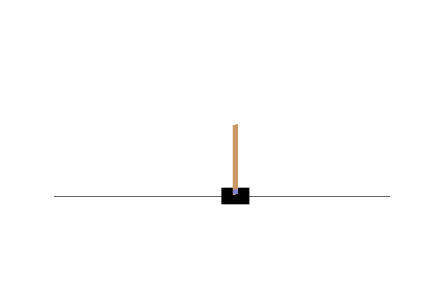
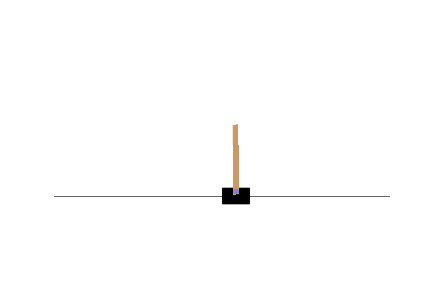
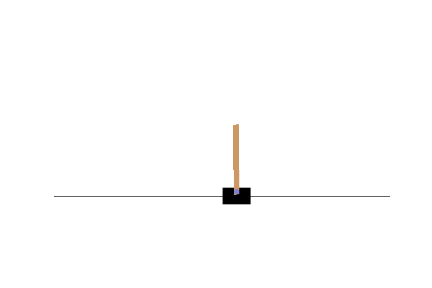
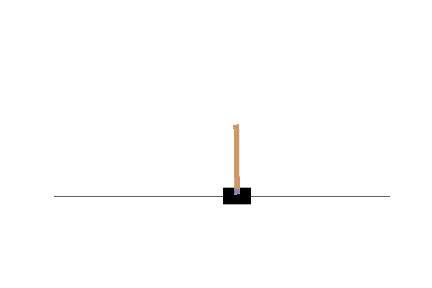
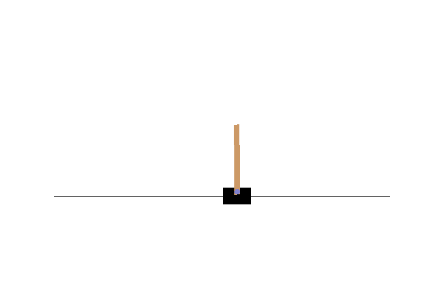
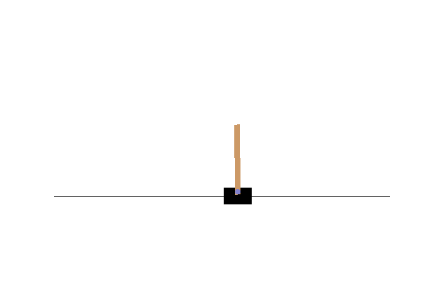
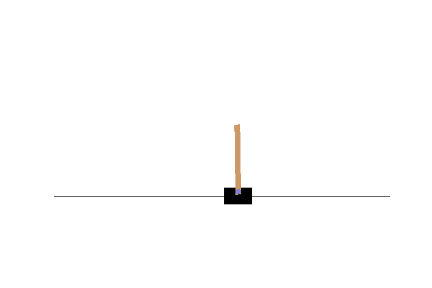
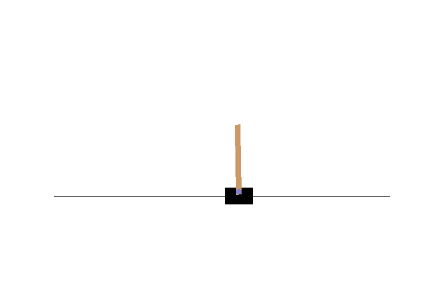
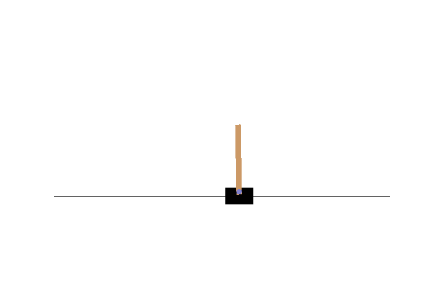
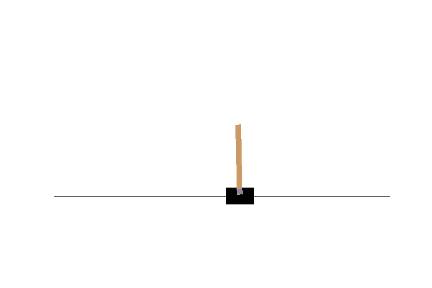
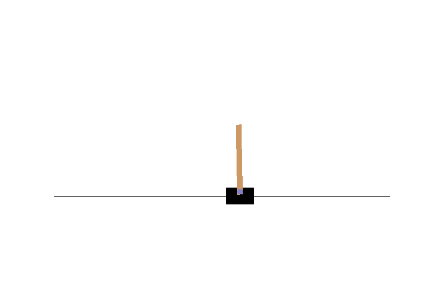
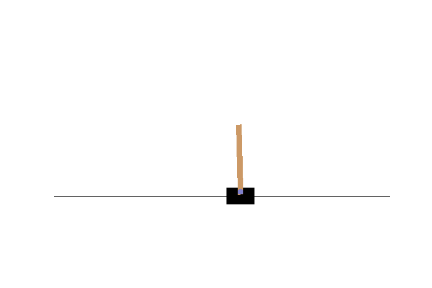
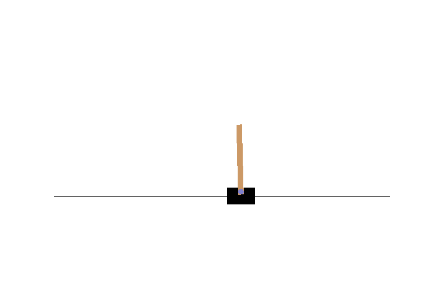
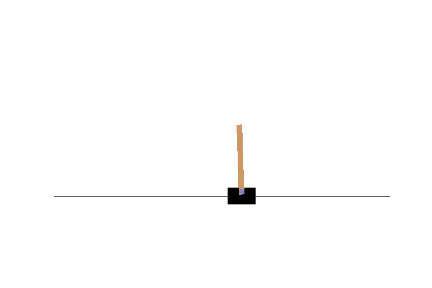
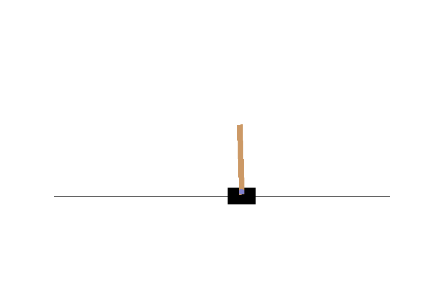
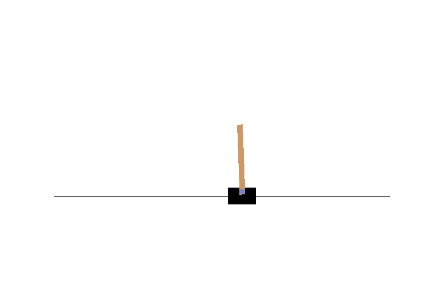
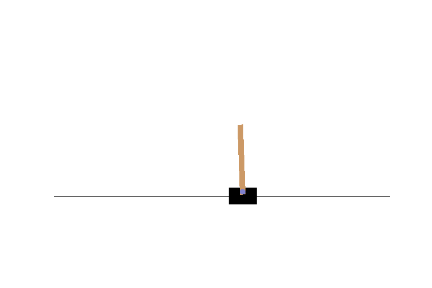
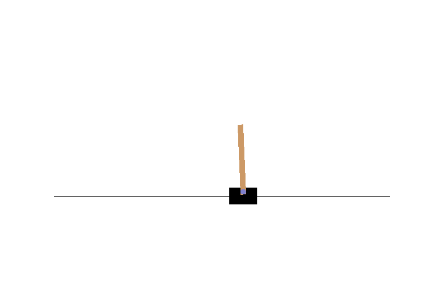
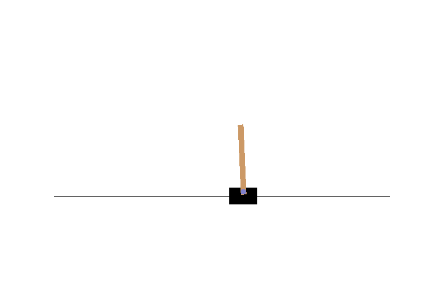
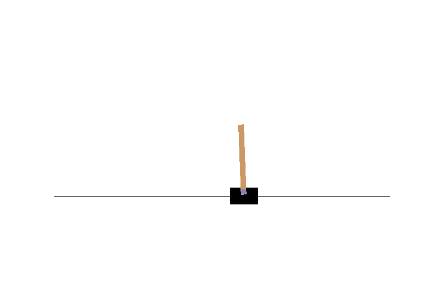
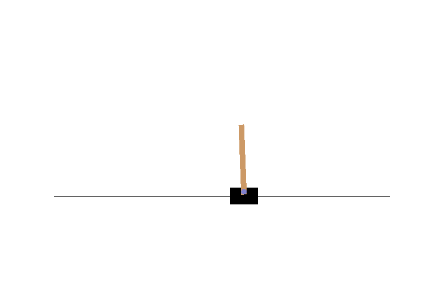
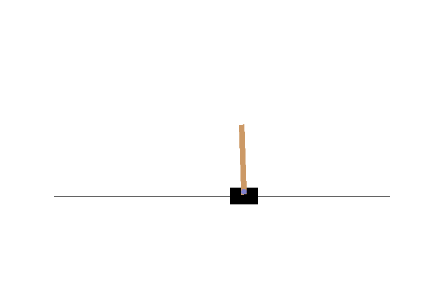
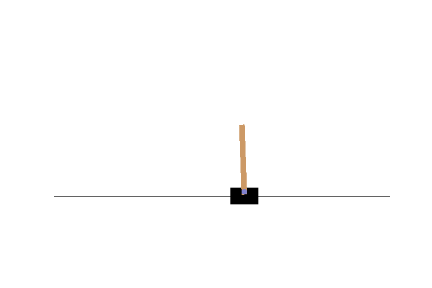
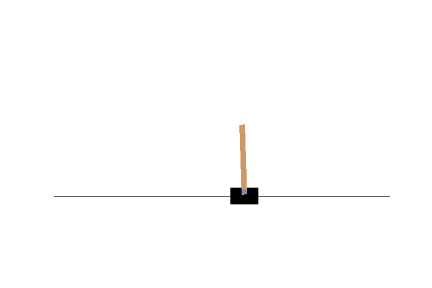
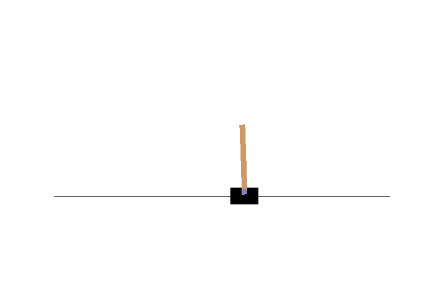
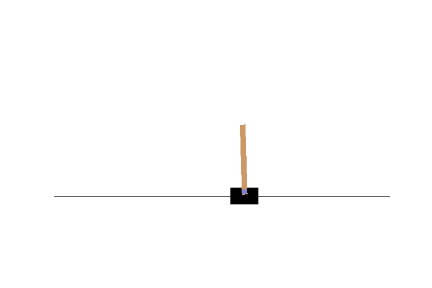
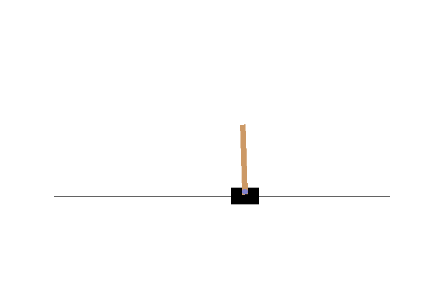
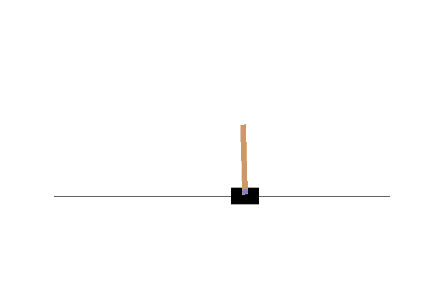
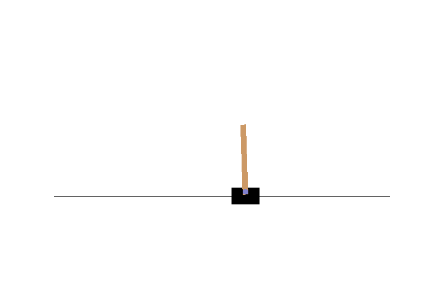
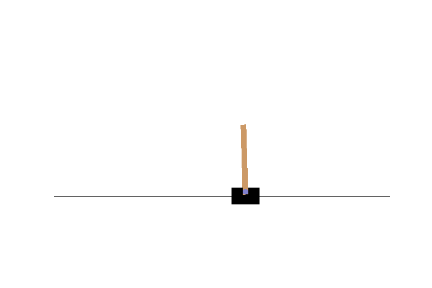
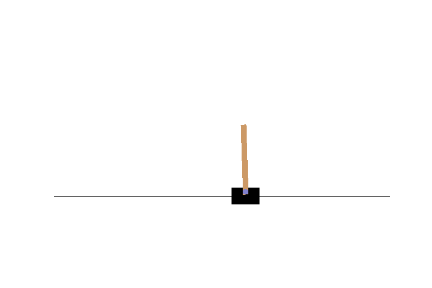
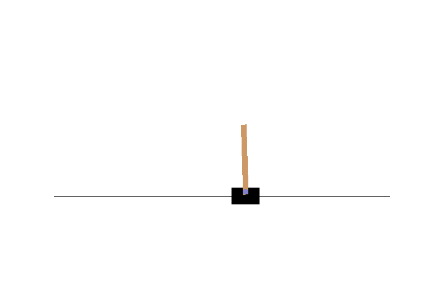
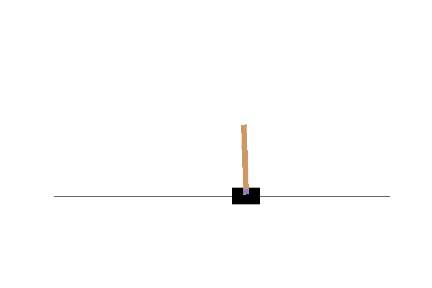
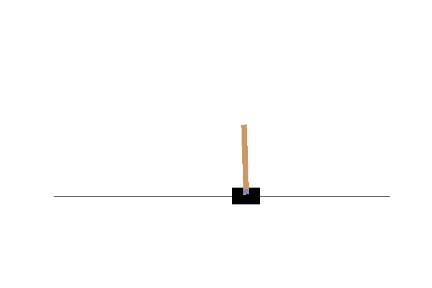
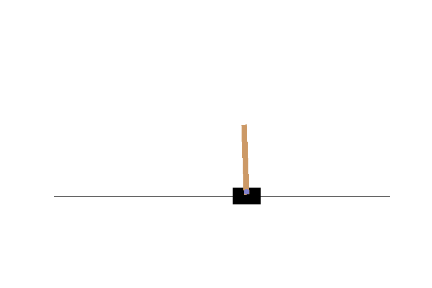
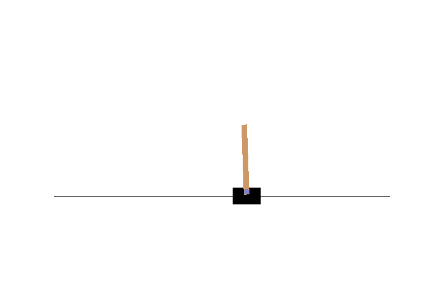

In [54]:
display_frames_as_gif(frames)

In [51]:
 D_in, H, D_out = 4, 150, 2
learning_rate = 0.0009

# 例題がleakyReLUを使っているので、合わせる。
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

# 以下のURLを参照
# https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb
# 中間層の情報を使って損失関数を定義し、評価用モデルと学習用モデルを使うところもすごい！
def createModelB(learning_rate=learning_rate):
    inp = layers.Input(shape=(D_in,), name="input_x")
    adv = layers.Input(shape=(1,), name="advantages")
    x = layers.Dense(H, 
                     activation=LeakyReLU(), 
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    out = layers.Dense(D_out, 
                       activation="softmax", 
                       kernel_initializer=glorot_uniform(seed=42),
                       name="out")(x)
    
    def custom_loss(y_true, y_pred):
        # pred is output from neural network, a is action index
        # r is return (sum of rewards to end of episode), d is discount factor
        return -K.sum(adv * K.log(y_pred)) # element-wise multipliy, then sum

    model_train = Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=custom_loss, optimizer=Adam(lr=learning_rate))
    model_predict = Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [29]:
model_train, model_predict = createModelB()
env = gym.make('CartPole-v0')
MAX_DUR = 200
MAX_EPISODES = 1000
gamma_ = 0.99
time_steps = []
durations = []
losses = []
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # list of state, action, rewards
    
    for t in range(MAX_DUR): #while in episode
        act_prob = model_predict.predict(curr_state.reshape(1, D_in))[0]
        action = np.random.choice(np.array([0,1]), p=act_prob)
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        transitions.append((prev_state, action, reward))
        if done:
            durations.append(t)
            break

    # Optimize policy network with full episode
    ep_len = len(transitions) # episode length
    time_steps.append(ep_len)
    preds = np.zeros(ep_len)
    rewards = np.zeros(ep_len)
    states = []

    for i in range(ep_len): #for each step in episode
        state, action, reward = transitions[i]
        pred = model_predict.predict(state.reshape(1, D_in))[0]
        preds[i] = pred[action]
        rewards[i] = reward
        states.append(state)
    #
    discounted_rewards =  discount_rewards(rewards)
    states = np.array(states).reshape(ep_len, D_in)
    loss = model_train.train_on_batch([states, discounted_rewards] , preds)
    losses.append(loss)
        
env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


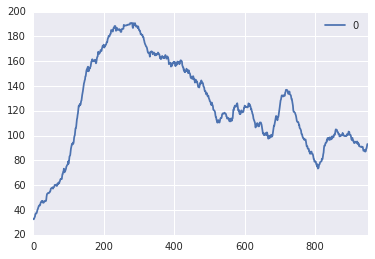

In [30]:
showResult(durations)

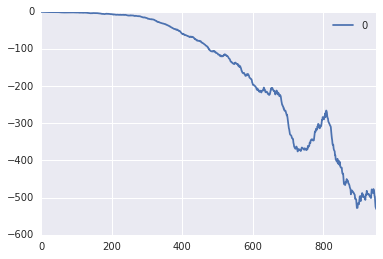

In [31]:
showResult(losses)